In [13]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import Xception, ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score, recall_score, f1_score, roc_curve
import matplotlib.pyplot as plt

def build_deepfake_detector_xception(input_shape=(256, 256, 3), learning_rate=0.0001):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy', AUC(name='auc')])
    return model

def build_deepfake_detector_resnet50(input_shape=(256, 256, 3), learning_rate=0.0001):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy', AUC(name='auc')])
    return model

def save_model(model, filename="deepfake_model.keras"):
    model.save(filename)
    print(f"Model saved to {filename}")

In [14]:
DATA_DIR = "/kaggle/input/faceforensics1600-videospreprocess/data"
IMG_HEIGHT, IMG_WIDTH, CHANNELS = 256, 256, 3
IMAGE_SIZE = (IMG_HEIGHT, IMG_WIDTH)
BATCH_SIZE = 32
EPOCHS = 15
sub_dirs = ['train', 'test', 'val']

def create_dataframe(DATA_DIR, sub_dir):
    data = {"file_path": [], "label": []}
    for label_dir, label in zip(['real', 'fake'], [1, 0]):
        folder_path = os.path.join(DATA_DIR, sub_dir, label_dir)
        for img_file in os.listdir(folder_path):
            data["file_path"].append(os.path.join(folder_path, img_file))
            data["label"].append(label)
    return pd.DataFrame(data)

for sub_dir in sub_dirs:
    df = create_dataframe(DATA_DIR, sub_dir)
    csv_path = f"{sub_dir}.csv"
    df.to_csv(csv_path, index=False)
    print(f"Saved {csv_path} with {len(df)} entries.")

train_df = pd.read_csv("train.csv").sample(frac=1, random_state=42).reset_index(drop=True)
valid_df = pd.read_csv("val.csv").sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.read_csv("test.csv").sample(frac=1, random_state=42).reset_index(drop=True)

for df in [train_df, valid_df, test_df]:
    df['label'] = df['label'].astype(str)

train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True)
datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
valid_generator = datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='file_path',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)
test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Saved train.csv with 11448 entries.
Saved test.csv with 3103 entries.
Saved val.csv with 1257 entries.
Found 11448 validated image filenames belonging to 2 classes.
Found 1257 validated image filenames belonging to 2 classes.
Found 3103 validated image filenames belonging to 2 classes.


In [15]:
choice = input("Choose model (1 for Xception, 2 for ResNet50): ")
input_shape = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)
if choice == '1':
    model = build_deepfake_detector_xception(input_shape=input_shape)
elif choice == '2':
    model = build_deepfake_detector_resnet50(input_shape=input_shape)
else:
    raise ValueError("Invalid choice. Use 1 or 2.")

checkpoint_path = '/kaggle/working/final_deepfake_model.keras'
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=[model_checkpoint]
)

model.load_weights(checkpoint_path)
save_model(model, "/kaggle/working/final_deepfake_model.keras")
# save_model(model, "final_deepfake_model.keras")

Choose model (1 for Xception, 2 for ResNet50):  1


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.8946 - auc: 0.9501 - loss: 0.2381
Epoch 1: val_accuracy improved from -inf to 0.99204, saving model to /kaggle/working/final_deepfake_model.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 183s 380ms/step - accuracy: 0.8948 - auc: 0.9503 - loss: 0.2377 - val_accuracy: 0.9920 - val_auc: 0.9999 - val_loss: 0.0269
Epoch 2/15
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.9967 - auc: 0.9999 - loss: 0.0099
Epoch 2: val_accuracy did not improve from 0.99204
358/358 ━━━━━━━━━━━━━━━━━━━━ 118s 329ms/step - accuracy: 0.9967 - auc: 0.9999 - loss: 0.0099 - val_accuracy: 0.9897 - val_auc: 0.9996 - val_loss: 0.0241
Epoch 3/15
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.9977 - auc: 1.0000 - loss: 0.0068
Epoch 3: val_accuracy did not improve from 0.99204
358/358 ━━━━━━━━━━━━━━━━━━━━ 118s 328ms/step - accuracy: 0.9977 - auc: 1.0000 - loss: 0.0068 - val_accuracy: 0.9753 - val_auc: 0.9999 - val_loss: 0.0522
Epoch 4/15
358/358 ━━━━━━━━━━━━━

In [16]:
test_generator.reset()
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator, verbose=1).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

# Metrics
auc_score = roc_auc_score(y_true, y_pred_prob)
map_score = average_precision_score(y_true, y_pred_prob)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"AUC: {auc_score:.4f}")
print(f"MAP: {map_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

97/97 ━━━━━━━━━━━━━━━━━━━━ 18s 152ms/step
AUC: 1.0000
MAP: 1.0000
Precision: 0.9994
Recall: 0.9994
F1 Score: 0.9994


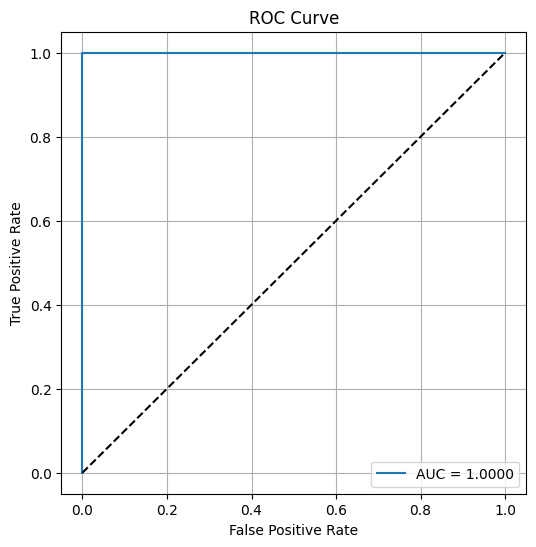

In [17]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()